Episode 1: Success - Steps: 2113 - Explore: 82 - Exploit: 2031
Episode 2: Failure - Steps: 7007 - Explore: 285 - Exploit: 6722
Episode 3: Failure - Steps: 1786 - Explore: 71 - Exploit: 1715
Episode 4: Success - Steps: 2029 - Explore: 90 - Exploit: 1939
Episode 5: Failure - Steps: 4423 - Explore: 160 - Exploit: 4263
Episode 6: Success - Steps: 7761 - Explore: 305 - Exploit: 7456
Episode 7: Success - Steps: 5048 - Explore: 168 - Exploit: 4880
Episode 8: Success - Steps: 2738 - Explore: 122 - Exploit: 2616
Episode 9: Success - Steps: 1098 - Explore: 43 - Exploit: 1055
Episode 10: Failure - Steps: 3289 - Explore: 118 - Exploit: 3171
       Episode  Step  Position  Velocity  Action  Reward   Q value
0            1     1 -0.524599 -0.001000      -1 -0.0100  0.000000
1            1     2 -0.524591  0.000007       1 -0.0085  0.000000
2            1     3 -0.523576  0.001015       1 -0.0085 -0.000850
3            1     4 -0.523562  0.000015      -1 -0.0100 -0.001000
4            1     5 -0.5225

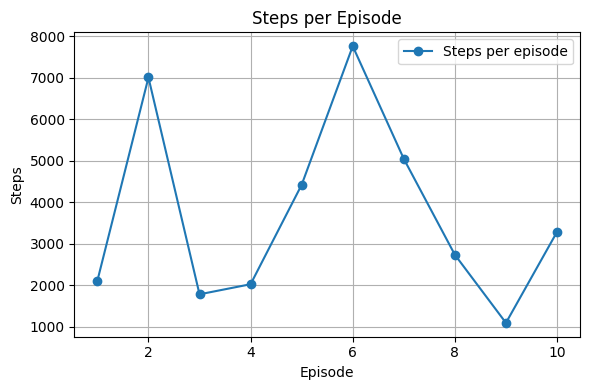

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Environment and physics parameters
min_position = -1.5
max_position = 1.8
goal_position_hill = math.pi / 6
force = 0.001
gravity = 0.0025
max_speed = 0.07
goal_position_valley = 3 * math.pi / 6 
start_position = -math.pi / 6
hill_position = np.cos(3 * goal_position_hill)
valley_gradient = np.cos(3 * goal_position_valley)


# Simulation parameters
num_steps = 20000
episodes = 10
gradient_bins = 60
velocity_bins = 20
action_space = [-1, 1]

# Q learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.04
epsilon_decay = 0.995
epsilon_min = 0.002

run = 0

min_gradient = gradient = np.cos(3 * max_position)
max_gradient = gradient = np.cos(3 * min_position)

hill_position = np.cos(3 * goal_position_hill)

#Bins for discretising the continous space
gradient_bin_edges = np.linspace(min_gradient, max_gradient, gradient_bins)

# Q table initialisation
Q = np.zeros((len(gradient_bin_edges), len(action_space)))

#data collection for debugging 
data = []
steps_per_episode = []

deceleration_threshold = 0.06  #threshold distance in meters to start decelerating
deceleration_factor = 0.1

def run_ep(episode_num, epsilon):
    steps_in_episode = 0
    xplore_no = 0
    exp_no = 0
    data_episode = []
    success = 0

    position = start_position
    velocity = 0.0
    done = False

    while not done:
        #discretise the position state but with gradient as the agent is unaware of it, carrying on from task 2
        gradient = np.cos(3 * position)
        state_g = np.digitize(gradient, gradient_bin_edges) - 1

          #choosing an action, explore of exploit
        if np.random.rand() < epsilon:
            action_index = np.random.choice(len(action_space))  #exploring
            xplore_no += 1
        else:
            action_index = np.argmax(Q[state_g])  #exploiting
            exp_no += 1

        action = action_space[action_index]

         #Physics stuff to  move the car
        applied_force = action * force
        velocity += applied_force - (gravity * gradient)
        velocity = np.clip(velocity, -0.07, 0.07)

        position += velocity
        position = np.clip(position, min_position, max_position)

        gradient = np.cos(3 * position) #update gradient


      #the reward logic
        reward = 10.0 if abs(position - goal_position_valley) < 0.01 else -0.01
        if position <= min_position:
            reward = -5.0
            
       #some more reward so that the agent would behave, increased it because now it is gradient
        if action > 0:
            reward += 0.0015

       #recording data
        data.append({
            "Episode": episode_num + 1,
            "Step": steps_in_episode + 1,
            "Position": position,
            "Velocity": velocity,
            "Action": action,
            "Reward": reward,
            "Q value": Q[state_g, action_index]
        })
        
           #get the new state 
        new_state_g = np.digitize(gradient, gradient_bin_edges) - 1

       #update Q learning
        best_future_q = np.max(Q[new_state_g])  # Position-only state
        Q[state_g, action_index] += alpha * (reward + gamma * best_future_q - Q[state_g, action_index])

        distance_to_goal = abs(position - goal_position_valley)

        #deceleration logic: slow down more as the agent approaches the goal
        if distance_to_goal <= deceleration_threshold: #when it's within the given threshold
            #reduce the velocity as the agent gets closer to the goal
            velocity *= (1 - deceleration_factor)  # Apply deceleration factor

        #clipping velocity to prevent overshooting type of behaviour
        velocity = np.clip(velocity, -max_speed, 0.06)

        steps_in_episode += 1

        #Termination conditions
        if abs(position - goal_position_valley) < 0.01 and abs(velocity) < 0.07:
            outcome = "Success"
            success += 1
            done = True
        elif position == min_position or position == max_position:
            outcome = "Failure"
            done = True
        elif steps_in_episode == num_steps:
            outcome = "Max steps taken"
            done = True

          
    print(f"Episode {episode_num + 1}: {outcome} - Steps: {steps_in_episode} - Explore: {xplore_no} - Exploit: {exp_no}")
    return data_episode, steps_in_episode
    

#run the episodes
for episode in range(episodes):
    episode_data, steps = run_ep(episode, epsilon)
    data.extend(episode_data)
    steps_per_episode.append(steps)
    epsilon = max(epsilon * epsilon_decay, epsilon_min)  #exponential decay
    
#convert the data into dataframe for viewing
df = pd.DataFrame(data)
print(df)

#plotting steps per episode for all 10 episodes
plt.figure(figsize=(6, 4))
plt.plot(range(1, episodes + 1), steps_per_episode, marker="o", label="Steps per episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps per Episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Success in run 1: 3, steps: 44176
Success in run 2: 5, steps: 23087
Success in run 3: 4, steps: 27246
Success in run 4: 2, steps: 34660
Success in run 5: 4, steps: 27074
Success in run 6: 3, steps: 25315
Success in run 7: 4, steps: 17953
Success in run 8: 6, steps: 33515
Success in run 9: 1, steps: 33086
Success in run 10: 3, steps: 25908
Total success:  35
Average step run:  29202.0
[1910.3 2467.5 2816.6 2229.3 2837.2 3220.2 2716.  3658.6 3249.9 4096.4]


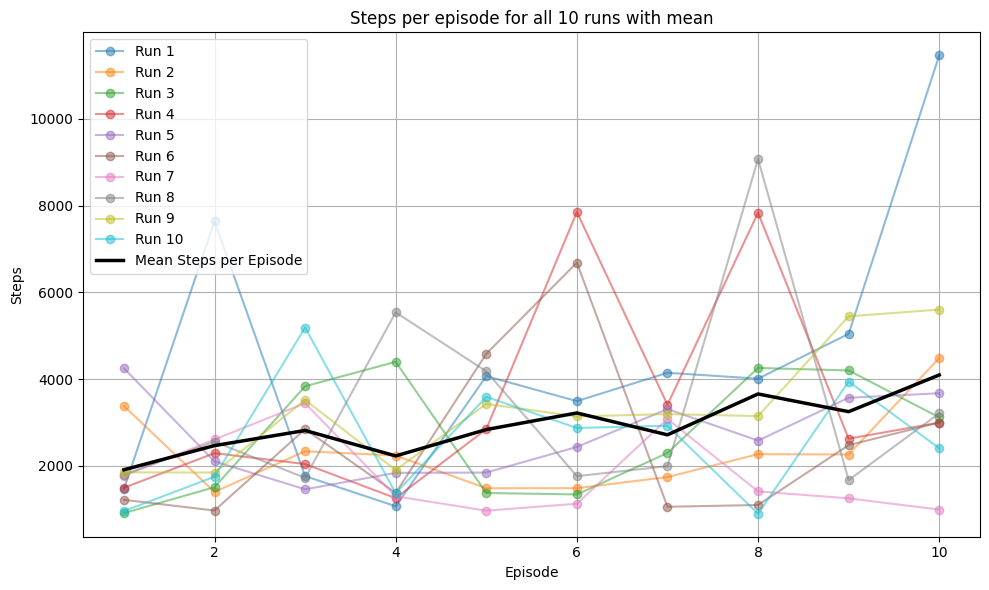

        Run  Episode  Step  Position  Velocity  Action   Reward   Q value
0         1        1     1 -0.524599 -0.001000      -1  -0.0100  0.000000
1         1        1     2 -0.524591  0.000007       1  -0.0085  0.000000
2         1        1     3 -0.523576  0.001015       1  -0.0085 -0.000850
3         1        1     4 -0.523562  0.000015      -1  -0.0100 -0.001000
4         1        1     5 -0.522547  0.001014       1  -0.0085 -0.001692
...     ...      ...   ...       ...       ...     ...      ...       ...
292015   10       10  2403  1.330348  0.062974       1  -0.0085 -0.079145
292016   10       10  2404  1.392999  0.062651       1  -0.0085 -0.079203
292017   10       10  2405  1.455270  0.062271       1  -0.0085 -0.079261
292018   10       10  2406  1.517120  0.061849       1  -0.0085 -0.079319
292019   10       10  2407  1.574185  0.057065       1  10.0015  0.429165

[292020 rows x 8 columns]


In [9]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Environment and physics parameters
min_position = -1.5
max_position = 1.8
goal_position_hill = math.pi / 6
force = 0.001
gravity = 0.0025
max_speed = 0.07
goal_position_valley = 3 * math.pi / 6 
start_position = -math.pi / 6
hill_position = np.cos(3 * goal_position_hill)
valley_gradient = np.cos(3 * goal_position_valley)


# Simulation parameters
num_steps = 20000
episodes = 10
gradient_bins = 60
velocity_bins = 20
action_space = [-1, 1]

# Q learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.04
epsilon_decay = 0.995
epsilon_min = 0.002

run = 0

min_gradient = gradient = np.cos(3 * max_position)
max_gradient = gradient = np.cos(3 * min_position)

hill_position = np.cos(3 * goal_position_hill)

#Bins for discretising the continous space
gradient_bin_edges = np.linspace(min_gradient, max_gradient, gradient_bins)

# Q table initialisation
Q = np.zeros((len(gradient_bin_edges), len(action_space)))

#data collection for debugging 
data = []
steps_per_run = []

deceleration_threshold = 0.06  #threshold distance in meters to start decelerating
deceleration_factor = 0.1

def run_ep(episode_num, epsilon):
    steps_in_episode = 0
    xplore_no = 0
    exp_no = 0
    data_episode = []
    success = 0

    position = start_position
    velocity = 0.0
    done = False

    while not done:
        #discretise the position state but with gradient as the agent is unaware of it, carrying on from task 2, one dimensional binning
        gradient = np.cos(3 * position)
        state_g = np.digitize(gradient, gradient_bin_edges) - 1

          #choosing an action, explore of exploit
        if np.random.rand() < epsilon:
            action_index = np.random.choice(len(action_space))  #exploring
            xplore_no += 1
        else:
            action_index = np.argmax(Q[state_g])  #exploiting
            exp_no += 1

        action = action_space[action_index]

         #Physics stuff to  move the car
        applied_force = action * force
        velocity += applied_force - (gravity * gradient)
        velocity = np.clip(velocity, -0.07, 0.07)

        position += velocity
        position = np.clip(position, min_position, max_position)

        gradient = np.cos(3 * position) #update gradient


      #the reward logic
        reward = 10.0 if abs(position - goal_position_valley) < 0.01 else -0.01
        if position <= min_position:
            reward = -5.0
            
       #some more reward so that the agent would behave, increased it because now it is gradient
        if action > 0:
            reward += 0.0015

       #recording data
        data.append({
            "Run": run + 1,
            "Episode": episode_num + 1,
            "Step": steps_in_episode + 1,
            "Position": position,
            "Velocity": velocity,
            "Action": action,
            "Reward": reward,
            "Q value": Q[state_g, action_index]
        })
        
           #get the new state 
        new_state_g = np.digitize(gradient, gradient_bin_edges) - 1

       #update Q learning
        best_future_q = np.max(Q[new_state_g])  # Position-only state
        Q[state_g, action_index] += alpha * (reward + gamma * best_future_q - Q[state_g, action_index])

        distance_to_goal = abs(position - goal_position_valley)

        #deceleration logic: slow down more as the agent approaches the goal
        if distance_to_goal <= deceleration_threshold: #when it's within the given threshold
            #reduce the velocity as the agent gets closer to the goal
            velocity *= (1 - deceleration_factor)  # Apply deceleration factor

        #clipping velocity to prevent overshooting type of behaviour
        velocity = np.clip(velocity, -max_speed, 0.06)

        steps_in_episode += 1

        #Termination conditions
        if abs(position - goal_position_valley) < 0.01 and abs(velocity) < 0.07:
            outcome = "Success"
            success += 1
            done = True
        elif position == min_position or position == max_position:
            outcome = "Failure"
            done = True
        elif steps_in_episode == num_steps:
            outcome = "Max steps taken"
            done = True

          
    #Uncomment this to see the runs in more detail
    #print(f'Run {run + 1} Episode {episode_num + 1}: {outcome} - Steps: {steps_in_episode} - Explore: {xplore_no} - Exploit: {exp_no}')
    return steps_in_episode, success

#Data for plotting for all 10 runs with 10 episodes
steps_per_run = []
total_success = 0
total_run_steps = 0  #to calculate total steps from all runs
for run in range(10): 
    Q = np.zeros((len(gradient_bin_edges), len(action_space)))  #resetting the Q table for each run
    steps_per_episode = []
    success_per_ep = 0 # successful outcomes per episode
    success_per_run =0  # successful outcomes per run, its data will be used for finding the sum of overall successful outcomes to measure performance
    epsilon = 0.04 # resetting epsilon for each run
    steps_one_run = 0  #collects steps for one run, its data will be used for calculating the average of all runs
    
    for episode in range(episodes):         
        steps, success_no = run_ep(episode, epsilon)        
        steps_per_episode.append(steps)
        success_per_ep += success_no
        steps_one_run += steps
        epsilon = max(epsilon * epsilon_decay, epsilon_min)   #exponential decay per episode

    steps_per_run.append(steps_per_episode)
    success_per_run += success_per_ep #successful outcomes per run
    total_success += success_per_run # total successful outcomes 
    total_run_steps += steps_one_run #total steps from all runs
    print(f"Success in run {run + 1}: {success_per_run}, steps: {steps_one_run}") #shows all successful outcomes in each run along with steps for each run

average_steps_per_run = total_run_steps / 10  # average steps per run to check performance

#printing data for performance
print("Total success: ", total_success) #shows the sum of all successful outcomes of all 10 runs
print("Average step run: ", average_steps_per_run)


#Calculate the mean steps per episode across all runs
mean_steps = np.mean(steps_per_run, axis=0)
print(mean_steps)


#Plotting all 10 runs and 10 episodes
plt.figure(figsize=(10, 6))
for run_idx, steps in enumerate(steps_per_run):
    plt.plot(range(1, episodes + 1), steps, marker="o", label=f"Run {run_idx + 1}", alpha=0.5)

plt.plot(range(1, episodes + 1), mean_steps, color="black", linewidth=2.5, label='Mean Steps per Episode')
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps per episode for all 10 runs with mean")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#printing the dataframe
df = pd.DataFrame(data)
print(df)
